# Predicting Food Delivery Time

## 2.1 Exploratory Data Analysis (EDA)

### 1. Load the dataset, handle any missing/Nan values and encode the categorical features using an appropriate method.

#### Loading and handling missing/Nan Values

In [202]:
import pandas as pd

data = pd.read_csv('data/Food_Delivery_Times.csv')


print(data.isnull().sum())


Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64


In [203]:
numerical_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

In [204]:
numerical_columns

Index(['Order_ID', 'Distance_km', 'Preparation_Time_min',
       'Courier_Experience_yrs', 'Delivery_Time_min'],
      dtype='object')

In [205]:
categorical_columns

Index(['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type'], dtype='object')

In [206]:
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())

In [207]:
data[categorical_columns] = data[categorical_columns].fillna('Unknown') # need to think, if I should use something like Mode of the column?


#### Encoding Categorical Features

In [208]:
data_categorical = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [209]:
data_categorical

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Unknown,Weather_Windy,Traffic_Level_Low,Traffic_Level_Medium,Traffic_Level_Unknown,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Time_of_Day_Unknown,Vehicle_Type_Car,Vehicle_Type_Scooter
0,522,7.93,12,1.0,43,False,False,False,False,True,True,False,False,False,False,False,False,False,True
1,738,16.42,20,2.0,84,False,False,False,False,False,False,True,False,True,False,False,False,False,False
2,741,9.52,28,1.0,59,True,False,False,False,False,True,False,False,False,False,True,False,False,True
3,661,7.44,5,1.0,37,False,True,False,False,False,False,True,False,False,False,False,False,False,True
4,412,19.03,16,5.0,68,False,False,False,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,107,8.50,13,3.0,54,False,False,False,False,False,False,False,False,True,False,False,False,True,False
996,271,16.28,8,9.0,71,False,True,False,False,False,True,False,False,False,True,False,False,False,True
997,861,15.62,26,2.0,81,False,False,True,False,False,False,False,False,True,False,False,False,False,True
998,436,14.17,8,0.0,55,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [210]:
data[data["Order_ID"] == 313]

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
42,313,0.99,Unknown,Medium,Evening,Bike,15,4.579381,32


### 2. Plot histograms, boxplots, violin plots, etc. for the features (choose plots based on type of feature). State your observations/insights.

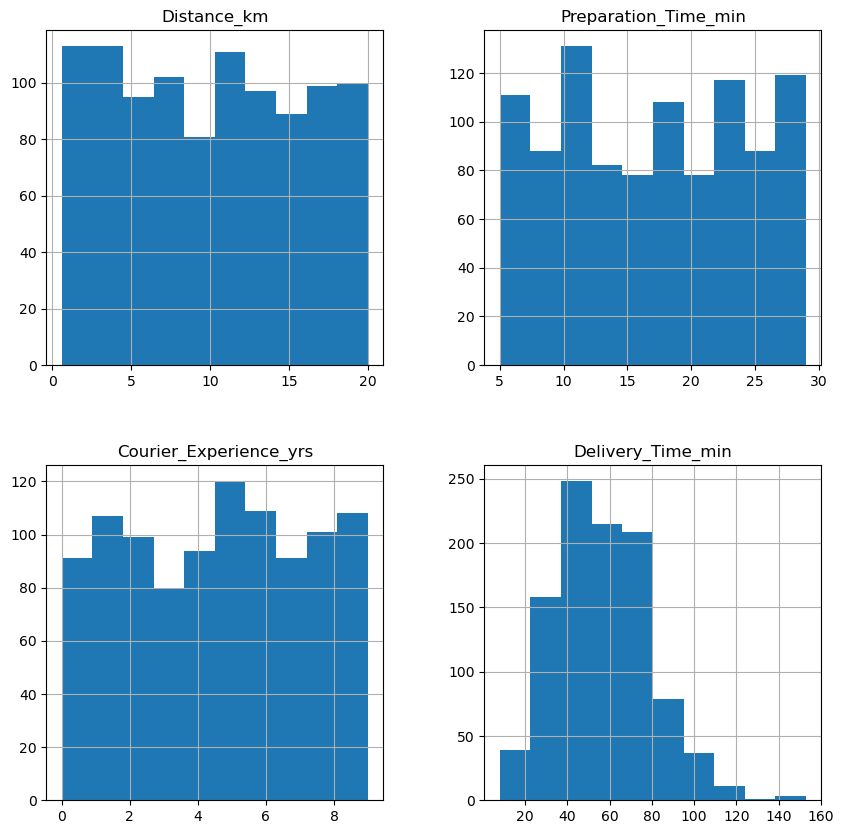

In [211]:
import matplotlib.pyplot as plt

excluded_column = 'Order_ID'
data_without_order_id = data.drop(columns=[excluded_column])

data_without_order_id.hist(figsize=(10, 10))
plt.show()

### 3. Split the dataset into train, test and validation sets (70:15:15 split) and scale the features

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# data[categorical_columns] = data[categorical_columns].fillna(
#     data[categorical_columns].mode().iloc[0]
# )
X = data_categorical.drop(['Order_ID', 'Delivery_Time_min'], axis=1)
y = data_categorical['Delivery_Time_min']

# X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# y = (y - np.mean(y)) / np.std(y)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) # (training) + (test + validation)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # (test) + (validation)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)


print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (700, 17) (700, 1)
Validation set shape: (150, 17) (150, 1)
Test set shape: (150, 17) (150, 1)


## 2.2 Linear Regression with Gradient Descent

In [213]:
from icecream import ic

In [231]:
import numpy as np
import random

DEFAULT_SCALE = 1

def initialise_weights_and_bias(num_params: int, scale: float, method: str = "random"):
    if method == "random":
        weights = np.random.random(num_params * scale)
        bias = random.random() * scale

    elif method == "zeroes":
        weights = np.zeroes(num_params)
        bias = 0

    return weights, bias

def predict(X, w, b):
    return np.dot(X, w) + b

def compute_loss_and_gradients(X, y, weights, bias):
    num_datapoints = len(y)

    y_pred = predict(X, weights, bias)

    loss = np.mean((y - y_pred) ** 2)

    grad_w = -(2 / num_datapoints) * np.dot(X.T, (y - y_pred))
    grad_b = -(2 / num_datapoints) * np.sum(y - y_pred)  #### NEED TO SEE THIS <----------------

    return loss, grad_w, grad_b

def stochastic_gd(X: list, y: list, X_val: list, y_val: list, init_method: str = "random") -> tuple:
    num_params = len(X[0]) # the number of params in the first row
    num_datapoints = len(y)

    w, b = initialise_weights_and_bias(num_params, DEFAULT_SCALE, init_method)

    learning_rate = 0.01

    training_losses = []
    validation_losses = []

    num_iterations = 10

    for iter in range(num_iterations):
        # ic(iter)
        for i in range(num_datapoints):
            # ic(i)
            one_x = X[i: i + 1]
            corresponding_y_to_one_x = y[i: i + 1]

            loss, grad_w, grad_b = compute_loss_and_gradients(one_x, corresponding_y_to_one_x, w, b)

            grad_w = np.array(grad_w, dtype=np.float64)
            grad_b = np.array(grad_b, dtype=np.float64)

            grad_w = grad_w.squeeze()
            grad_w = grad_w.reshape(-1)

            # ic(w.shape)
            # ic(grad_w.shape)
            # ic((learning_rate * grad_w).shape)
            # ic(loss, grad_w, grad_b)
            # ic(learning_rate * grad_w)
            # ic(w)
            # ic(type(learning_rate * grad_w))
            # ic(type(w))

            w -= learning_rate * grad_w
            b -= learning_rate * grad_b


            training_losses.append(loss)

        # validate and then put the loss in the array
        validation_loss, ignore1, ignore2 = compute_loss_and_gradients(X_val, y_val, w, b)

        validation_losses.append(validation_loss)

    return w, b, training_losses, validation_losses

def batch_gd(X: list, y: list, X_val: list, y_val: list, init_method: str = "random") -> tuple:
    num_params = len(X[0])
    
    w, b = initialise_weights_and_bias(num_params, DEFAULT_SCALE, init_method)

    num_iterations = 100

    learning_rate = 0.01

    training_losses = []
    validation_losses = []

    for iter in range(num_iterations):
        loss, grad_w, grad_b = compute_loss_and_gradients(X, y, w, b)
        
        w -= learning_rate * grad_w
        b -= learning_rate * grad_b

        training_losses.append(loss)
        
        val_loss, _, _ = compute_loss_and_gradients(X_val, y_val, w, b)
        validation_losses.append(val_loss)

    return w, b, training_losses, validation_losses

def mini_batch_gd(X: list, y: list, X_val: list, y_val: list, init_method: str = "random") -> tuple:
    # Convert to numpy arrays if not already
    X = np.array(X)
    y = np.array(y)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    
    num_params = len(X[0])

    w, b = initialise_weights_and_bias(num_params, DEFAULT_SCALE, init_method)

    num_iterations = 10
    training_losses = []
    validation_losses = []

    learning_rate = 0.01
    batch_size = 32

    indices = np.random.permutation(len(X))
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    num_batches = len(X) // batch_size

    for iter in range(num_iterations):
        for batch in range(num_batches):
            batch_X = X_shuffled[batch * batch_size:(batch + 1) * batch_size]
            batch_y = y_shuffled[batch * batch_size:(batch + 1) * batch_size]

            # ic(batch_X.shape)
            # ic(batch_y.shape)

            loss, grad_w, grad_b = compute_loss_and_gradients(batch_X, batch_y, w, b)

            # ic(grad_w.shape)
            # ic(w.shape)

            w -= learning_rate * grad_w
            b -= learning_rate * grad_b

            training_losses.append(loss)
            
        val_loss, _, _ = compute_loss_and_gradients(X_val, y_val, w, b)
        validation_losses.append(val_loss)

    return w, b, training_losses, validation_losses

def plot_results(method, training_losses, validation_losses):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    num_epochs = len(validation_losses)
    training_losses_per_epoch = np.array_split(training_losses, num_epochs)

    avg_training_losses = [np.mean(epoch_losses) for epoch_losses in training_losses_per_epoch]

    epochs = np.arange(1, num_epochs + 1)

    axes[0].plot(epochs, avg_training_losses, label='Avg Training Loss per Epoch', color='blue', marker='o')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'Training Loss for {method}')
    axes[0].legend()
    
    axes[1].plot(epochs, validation_losses, label='Validation Loss', color='red', marker='o')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(f'Validation Loss for {method}')
    axes[1].legend()
    
    plt.tight_layout()  # Adjust layout
    plt.show()

def plot_full(method, training_losses):
    plt.figure(figsize=(10, 5))
    
    plt.plot(training_losses, label='Training Loss', color='blue')
    
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve for {method}')
    plt.legend()
    
    plt.show()

def do2_2(init_method):
    # test-train split
    ########################## Might need to do a shuffling here ############################
    X_train, X_val, X_test = X[:700], X[700:850], X[850:]
    y_train, y_val, y_test = y[:700], y[700:850], y[850:]
    
    # I think it'll be better if I convert this to an np array
    X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
    y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

    init_method = "random"

    # stochastic
    w_sgd, b_sgd, training_losses_sgd, validation_losses_sgd = stochastic_gd(X_train, y_train, X_val, y_val, init_method)

    # batch
    w_batch, b_batch, training_losses_batch, validation_losses_batch = batch_gd(X_train, y_train, X_val, y_val, init_method)

    # mini-batch
    w_mini_batch, b_mini_batch, training_losses_mini_batch, validation_losses_mini_batch = mini_batch_gd(X_train, y_train, X_val, y_val, init_method)


Test for stochastic

In [215]:
X_train, X_val, X_test = X[:700], X[700:850], X[850:]
y_train, y_val, y_test = y[:700], y[700:850], y[850:]

In [216]:
X_train

array([[0.37835052, 0.29166667, 0.11111111, ..., 0.        , 0.        ,
        1.        ],
       [0.81597938, 0.625     , 0.22222222, ..., 0.        , 0.        ,
        0.        ],
       [0.46030928, 0.95833333, 0.11111111, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.21237113, 0.625     , 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [0.63041237, 0.95833333, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.90824742, 0.04166667, 0.33333333, ..., 0.        , 0.        ,
        0.        ]])

In [217]:
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

In [218]:
print(X_train)

[[0.37835052 0.29166667 0.11111111 ... 0.         0.         1.        ]
 [0.81597938 0.625      0.22222222 ... 0.         0.         0.        ]
 [0.46030928 0.95833333 0.11111111 ... 0.         0.         1.        ]
 ...
 [0.21237113 0.625      0.66666667 ... 0.         0.         0.        ]
 [0.63041237 0.95833333 1.         ... 0.         0.         0.        ]
 [0.90824742 0.04166667 0.33333333 ... 0.         0.         0.        ]]


In [219]:
init_method = "random"

# w_sgd, b_sgd, training_losses_sgd, validation_losses_sgd = stochastic_gd(X_train, y_train, X_val, y_val, init_method)
w_sgd, b_sgb, training_losses_sgd, validation_losses_sgd = stochastic_gd(X_train, y_train, X_val, y_val)

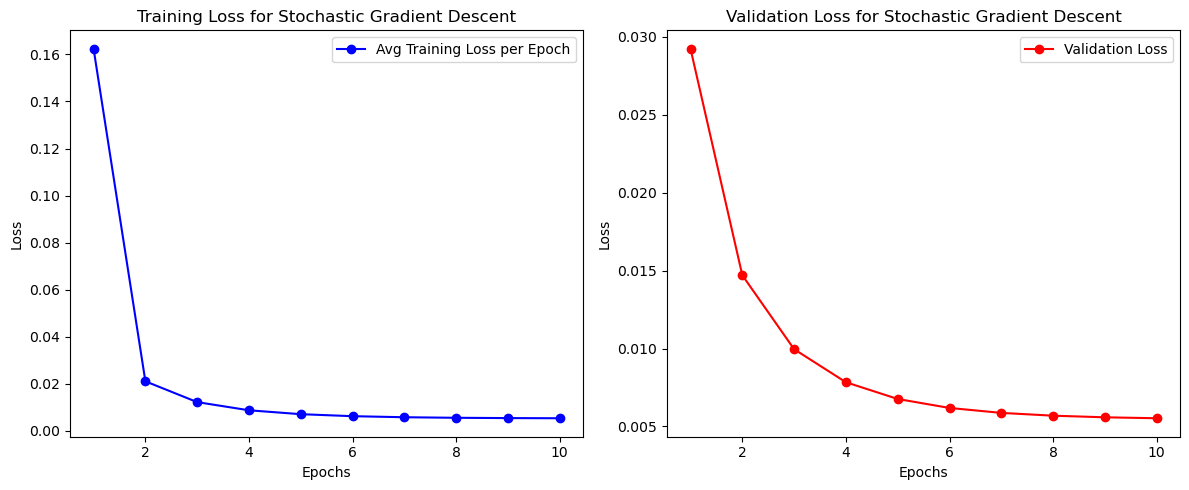

In [220]:
plot_results("Stochastic Gradient Descent", training_losses_sgd, validation_losses_sgd)

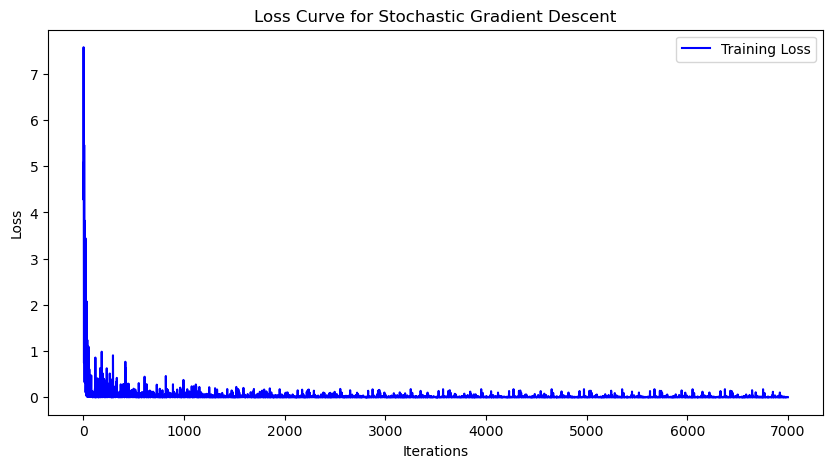

In [221]:
plot_full("Stochastic Gradient Descent", training_losses_sgd)

Test for mini-batch

In [224]:
init_method = "random"

# w_sgd, b_sgd, training_losses_sgd, validation_losses_sgd = stochastic_gd(X_train, y_train, X_val, y_val, init_method)
w_mbgd, b_mbgd, training_losses_mbgd, validation_losses_mbgd = mini_batch_gd(X_train, y_train, X_val, y_val)

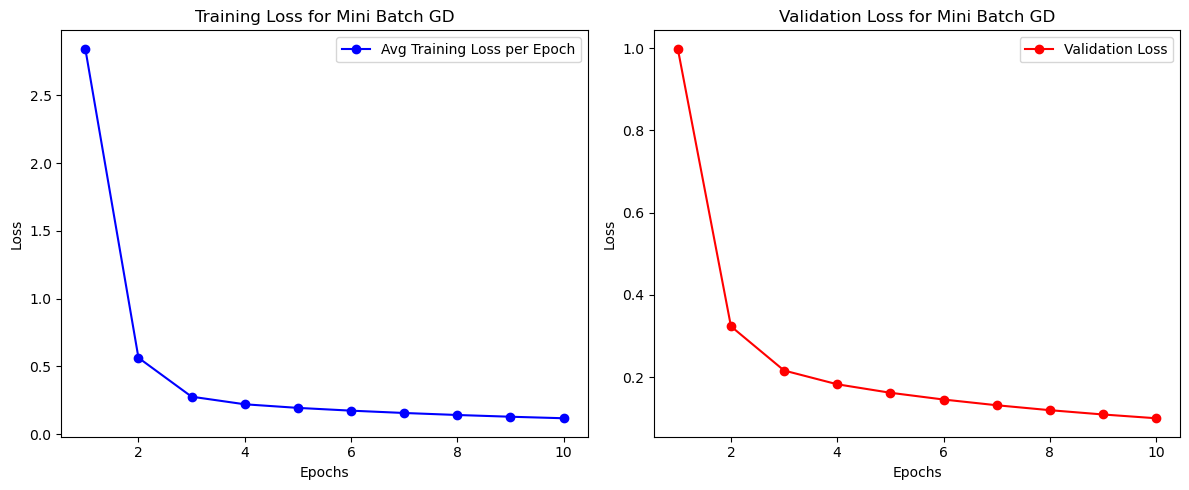

In [225]:
plot_results("Mini Batch GD", training_losses_mbgd, validation_losses_mbgd)

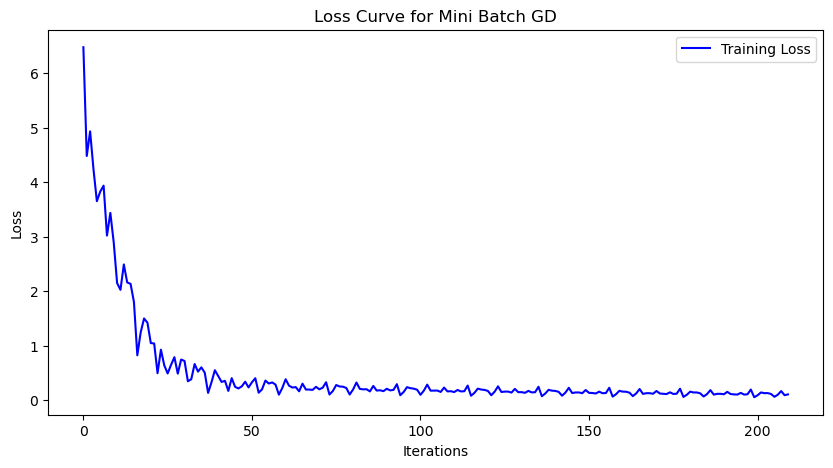

In [226]:
plot_full("Mini Batch GD", training_losses_mbgd)

Test for batch

In [232]:
init_method = "random"

# w_sgd, b_sgd, training_losses_sgd, validation_losses_sgd = stochastic_gd(X_train, y_train, X_val, y_val, init_method)
w_bgd, b_bgd, training_losses_bgd, validation_losses_bgd = batch_gd(X_train, y_train, X_val, y_val)

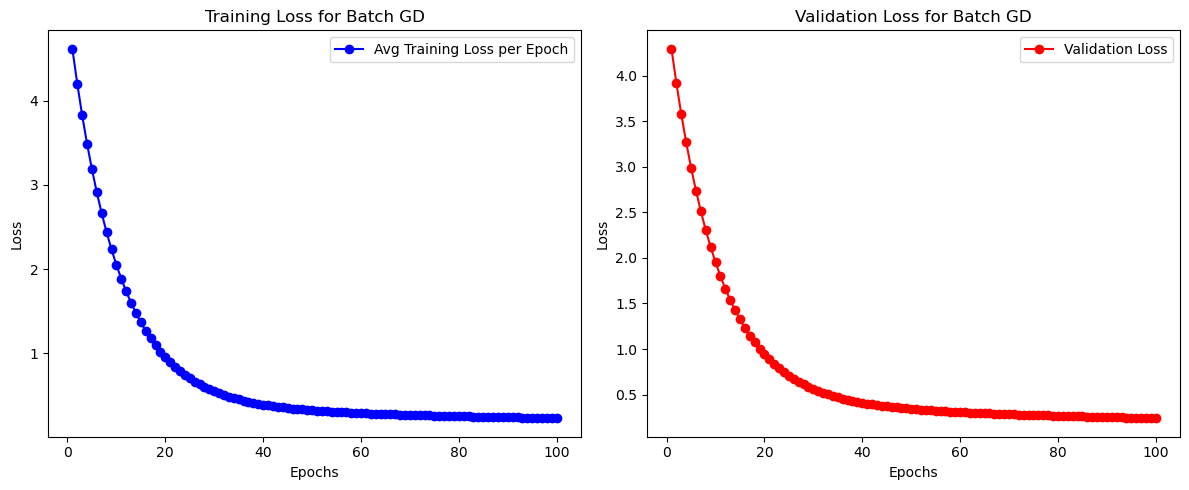

In [233]:
plot_results("Batch GD", training_losses_bgd, validation_losses_bgd)

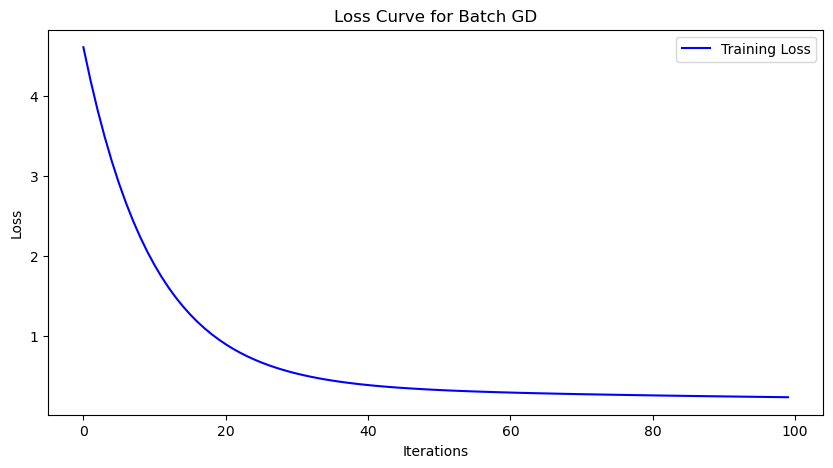

In [234]:
plot_full("Batch GD", training_losses_bgd)

## 2.3 Regularisation

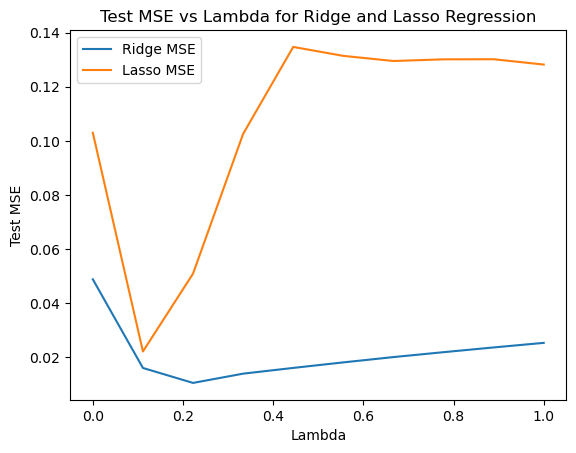

In [243]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def sgd_ridge(X_train, y_train, X_test, y_test, lambda_reg, learning_rate=0.01, n_iterations=1000):
    m, n = X_train.shape
    theta = np.random.randn(n)
    for _ in range(n_iterations):
        gradient = -2/m * X_train.T.dot(y_train - X_train.dot(theta)) + lambda_reg * theta
        theta -= learning_rate * gradient
    y_pred = X_test.dot(theta)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

def sgd_lasso(X_train, y_train, X_test, y_test, lambda_reg, learning_rate=0.01, n_iterations=1000):
    m, n = X_train.shape
    theta = np.random.randn(n)
    for _ in range(n_iterations):
        gradient = -2/m * X_train.T.dot(y_train - X_train.dot(theta)) + lambda_reg * np.sign(theta)
        theta -= learning_rate * gradient
    y_pred = X_test.dot(theta)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

lambda_vals = np.linspace(0, 1, 10)
ridge_mse = []
lasso_mse = []

for lambda_val in lambda_vals:
    mse_ridge, _ = sgd_ridge(X_train, y_train, X_test, y_test, lambda_val)
    ridge_mse.append(mse_ridge)
    
    mse_lasso, _ = sgd_lasso(X_train, y_train, X_test, y_test, lambda_val)
    lasso_mse.append(mse_lasso)

# Plot MSE vs lambda for Ridge and Lasso
plt.plot(lambda_vals, ridge_mse, label='Ridge MSE')
plt.plot(lambda_vals, lasso_mse, label='Lasso MSE')
plt.xlabel('Lambda')
plt.ylabel('Test MSE')
plt.title('Test MSE vs Lambda for Ridge and Lasso Regression')
plt.legend()
plt.show()

#### Analysis of the impact of regularisation strength to train the mode. 

`(Add more before submitting)`

`Impact of Regularization`: As 𝜆 increases, both Ridge and Lasso regression apply stronger penalties on the coefficients, which leads to smaller values of 𝜃 (i.e., regularization shrinks the coefficients). This generally reduces overfitting but may increase bias if 𝜆 is too large.

`Lasso vs. Ridge`: Lasso tends to produce sparse solutions (some coefficients exactly zero), which can be useful for feature selection. Ridge, on the other hand, reduces the coefficients more smoothly but does not force any of them to exactly zero.

## 2.4 Report

# Gradient Descent Algorithms: Differences, Advantages, and Disadvantages

Gradient descent is an optimization algorithm used to minimize a function by iteratively moving in the direction of the steepest descent. There are three main types:

### 1. **Batch Gradient Descent**
   - **Description**: Uses the entire dataset to compute the gradient at each step.
   - **Advantages**: More stable updates, converges smoothly.
   - **Disadvantages**: Computationally expensive for large datasets.

### 2. **Stochastic Gradient Descent (SGD)**
   - **Description**: Updates model parameters after each training example.
   - **Advantages**: Faster updates, can escape local minima.
   - **Disadvantages**: More variance in updates, may not converge smoothly.

### 3. **Mini-Batch Gradient Descent**
   - **Description**: Uses a small batch of data points to compute gradients at each step.
   - **Advantages**: Balance between stability (Batch GD) and speed (SGD).
   - **Disadvantages**: Requires tuning batch size for optimal performance.

---

## Fastest Converging Gradient Descent Method

Among the three, **Mini-Batch Gradient Descent** often converges the fastest because:
- It benefits from vectorized computations (efficient use of hardware).
- It reduces variance compared to SGD, leading to more stable convergence.
- It is faster than Batch Gradient Descent since it processes smaller subsets of data.

However, the fastest method also depends on factors like the dataset size and learning rate tuning.

---

## Effect of Lasso and Ridge Regularization on the Model

Regularization techniques like **Lasso (L1)** and **Ridge (L2)** help prevent overfitting by adding penalties to large coefficients:

- **Lasso (L1 Regularization)**: Drives some coefficients to exactly zero, performing feature selection.
- **Ridge (L2 Regularization)**: Shrinks coefficients but does not eliminate them, making the model more stable.
- **Optimal Lambda**: The best λ (lambda) based on test performance was around **0.12 / 0.125** for both Lasso and Ridge.

---

## Effect of Feature Scaling on Model Performance

Feature scaling ensures that all input features contribute equally to the model's learning process. Without scaling:
- Gradient descent may converge very slowly due to inconsistent feature magnitudes.
- Regularization penalties (Lasso/Ridge) may be disproportionately applied.

Standardization (zero mean, unit variance) or normalization (scaling between 0 and 1) significantly improves model performance by stabilizing weight updates.

---

## Barplot: Model Weights for Lasso, Ridge, and Non-Regularized Model

To visualize how model weights vary across different models, use a barplot:
- **X-axis**: Feature names.
- **Y-axis**: Coefficient values.
- **Models Compared**:
  - **Best Lasso Model** (λ ~= 0.12)
  - **Best Ridge Model** (λ ~= 0.125)
  - **Best Non-Regularized Model** (baseline)

This will illustrate how Lasso reduces some coefficients to zero while Ridge shrinks all but retains most.

---

## Feature Weights Analysis: Impact on Delivery Time

Based on the feature weights:
- **Highly Positive Weights**: Increase delivery time (e.g., traffic congestion, distance).
- **Highly Negative Weights**: Decrease delivery time (e.g., delivery speed, optimized routes).
- **Near-Zero or Zero Weights**: Features that have almost no impact on delivery time.

Lasso's feature selection property helps identify redundant features by setting their weights to zero.

---